 Optimize the Eduati 2020 model using BNMPy optimizer

In the Eduati 2020 paper (doi: 10.15252/msb.209690, link: https://www.ncbi.nlm.nih.gov/pubmed/32073727), 
a logical model has been trained using drug response data to predict new treatment data using the CNOR-ODE tool.   
  
Here, we are trying to optimizie the model using the same data they provided, but with our PBN optimizer.

## Training data
Drug response data was obtained from GitHub repository: https://github.com/saezlab/ModelingMPS/tree/master/data/MIDAS_files

In [1]:
import sys
import importlib
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
sys.path.append('./src')
import BNMPy
import Optimizer
# from BNMPy import PBN, BMatrix, booleanNetwork, vis
# from BNMPy.steady_state import SteadyStateCalculator
# from Optimizer.experiment_data import ExperimentData
# from Optimizer.parameter_optimizer import ParameterOptimizer
# from Optimizer.model_compressor import compress_model
# from Optimizer.sensitivity_analysis import sensitivity_analysis

network_file = '../input_files/Eduati2020_standardized_no_expand.txt'
data_aspc1_file = '../data/Eduati2020_AsPC1_cleaned_reduced.csv'

The data was cleaned by changing names of genes to a standard HGNC symbol, and convert to a format that complys with our ExperimentData.

In [2]:
# Load it in BNMPy
data_aspc1 = Optimizer.ExperimentData.load_from_csv(data_aspc1_file)
data_aspc1

[{'id': 1,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['EGFR'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.317699657}},
 {'id': 2,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['JAK1'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.270094786}},
 {'id': 3,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['MAP2K1'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.240832496}},
 {'id': 4,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['AktM'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.370602546}},
 {'id': 5,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['IKBKB'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.400900604}},
 {'id': 6,
  'stimuli': ['EGF'],
  'stimuli_efficacy': [1.0],
  'inhibitors': ['PIK3CA'],
  'inhibitors_efficacy': [1.0],
  'measurements': {'CASP3': 0.369222631}},
 {'id': 7,
  'sti

In [3]:
Optimizer.ExperimentData.get_experiment_summary(data_aspc1)

{'num_experiments': 7,
 'unique_stimuli': ['TNF', 'EGF'],
 'unique_inhibitors': ['AktM', 'IKBKB', 'MAP2K1', 'PIK3CA', 'EGFR', 'JAK1'],
 'unique_measured_nodes': ['CASP3'],
 'value_ranges': {'CASP3': {'min': 0.240832496, 'max': 0.400900604}},
 'stimuli_efficacy_ranges': {'EGF': {'min': 1.0, 'max': 1.0},
  'TNF': {'min': 1.0, 'max': 1.0}},
 'inhibitors_efficacy_ranges': {'EGFR': {'min': 1.0, 'max': 1.0},
  'JAK1': {'min': 1.0, 'max': 1.0},
  'MAP2K1': {'min': 1.0, 'max': 1.0},
  'AktM': {'min': 1.0, 'max': 1.0},
  'IKBKB': {'min': 1.0, 'max': 1.0},
  'PIK3CA': {'min': 1.0, 'max': 1.0}}}

## Define alternative rule for PBN

We will just use self-loop as the alternative rules for now.  

E.g., for `TNFRSF1A = NFKB1 | TNF` in BN, its rule in PBN will be: 
   
`TNFRSF1A = NFKB1 | TNF, p`  
`TNFRSF1A = TNFRSF1A, 1-p`   
where p is the probability to be optimized. We will just put a 0.5 here as placeholder.

In [2]:
with open(network_file, 'r') as f:
    bn_string = f.read()

pbn_string, nodes_to_optimize = BNMPy.BN2PBN(bn_string, prob=0.5, fixed_nodes=['CASP3'])
pbn = BNMPy.load_pbn_from_string(pbn_string)

print("PBN string:")
print(pbn_string)

No initial state provided, using a random initial state
PBN loaded successfully. There are 46 genes in the network.
PBN string:
AKT1 = AktM & AktP, 0.5
AKT1 = AKT1, 0.5
APAF1 = TP53, 0.5
APAF1 = APAF1, 0.5
APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.5
APC = APC, 0.5
AktM = PDPK1 & PIP3, 0.5
AktM = AktM, 0.5
AktP = PDPK1 & PIP3, 0.5
AktP = AktP, 0.5
BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.5
BAD = BAD, 0.5
BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.5
BCL2L1 = BCL2L1, 0.5
BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.5
BID = BID, 0.5
BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.5
BIRC2 = BIRC2, 0.5
CASP12 = CASP7, 0.5
CASP12 = CASP12, 0.5
CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 1
CASP6 = ! BIRC2 | CASP3, 0.5
CASP6 = CASP6, 0.5
CASP7 = ! BIRC2 | CASP8 | APC, 0.5
CASP7 = CASP7, 0.5
CASP8 = complexIIB | complexIIA | CASP6, 0.5
CASP8 = CASP8, 0.5
CASP9 = ! BIRC2 | ! MAPK1 | CASP3 | CASP12 | ! AKT1, 0.5
CASP9 = CASP9, 0.5
CFLAR = NFKB1, 0.5
CFLAR = CFLAR, 0.5
EGF = EGF, 1
EGFR = EGF, 0.5
EGFR = EGFR,

In [3]:
print(f"There are {len(nodes_to_optimize)} nodes to optimize:")
print(nodes_to_optimize)

There are 42 nodes to optimize:
['AKT1', 'APAF1', 'APC', 'AktM', 'AktP', 'BAD', 'BCL2L1', 'BID', 'BIRC2', 'CASP12', 'CASP6', 'CASP7', 'CASP8', 'CASP9', 'CFLAR', 'EGFR', 'IKBKB', 'JAK1', 'KRAS', 'MAP2K1', 'MAP2K4', 'MAP3K1', 'MAP3K14', 'MAPK1', 'MAPK8', 'MDM2', 'Mito', 'NFKB1', 'NFKBIA', 'PIK3CA', 'PIP3', 'PTEN', 'RAF1', 'RPS6KA1', 'SOS1', 'STAT3', 'TNFAIP3', 'TNFRSF1A', 'TP53', 'complexI', 'complexIIA', 'complexIIB']


## KG extension

In [46]:
network = BNMPy.load_network_from_file(network_file)
genes = network.nodeDict.keys()

No initial state provided, using a random initial state
Network loaded successfully. There are 46 genes in the network.


In [29]:
# get the knowledge graph-derived network
KG_string, relations = BNMPy.load_signor_network(genes, joiner='inhibitor_wins', score_cutoff=0.6)
print(KG_string)

Applied score cutoff 0.6, filtered to 16059/40940 edges
number of genes found: 39
[207, 317, 324, 572, 598, 637, 329, 100506742, 836, 839, 840, 841, 842, 8837, 1950, 1956, 3551, 3716, 3845, 5604, 6416, 4214, 9020, 5594, 5599, 4193, 4790, 4792, 5170, 5290, 5728, 5894, 6195, 6654, 6774, 7124, 7128, 7132, 7157]
AKT1 = (!CASP3 & !PTEN) & (PDPK1 | PIK3CA) # Scores: CASP3_inhibit:0.602; PDPK1_activate:0.749; PIK3CA_activate:0.816; PTEN_inhibit:0.634
APAF1 = !BCL2L1 # Scores: BCL2L1_inhibit:0.841
APC = APC
BAD = (!MAPK8 & !AKT1 & !RAF1) & BCL2L1 # Scores: MAPK8_inhibit:0.686; AKT1_inhibit:0.823; RAF1_inhibit:0.66; BCL2L1_activate:0.849
BCL2L1 = (!MAPK8 & !BAD & !BID) # Scores: MAPK8_inhibit:0.774; BAD_inhibit:0.849; BID_inhibit:0.859
BID = CASP8 # Scores: CASP8_activate:0.88
BIRC2 = BIRC2
BIRC3 = NFKB1 # Scores: NFKB1_activate:0.629
CASP3 = !MAPK14 & (CASP9 | CASP8) # Scores: MAPK14_inhibit:0.774; CASP9_activate:0.639; CASP8_activate:0.727
CASP6 = (CASP3 | CASP8) # Scores: CASP3_activate:0.61

In [48]:
# get the knowledge graph-derived network
KG_string, relations = BNMPy.load_signor_network(genes, joiner='&', score_cutoff=0.5)
print(KG_string)

number of genes found: 39
[207, 317, 324, 572, 598, 637, 329, 100506742, 836, 839, 840, 841, 842, 8837, 1950, 1956, 3551, 3716, 3845, 5604, 6416, 4214, 9020, 5594, 5599, 4193, 4790, 4792, 5170, 5290, 5728, 5894, 6195, 6654, 6774, 7124, 7128, 7132, 7157]
AKT1 = (! CASP3) & (PDPK1) & (! PTEN) & (PIK3CA) # Scores: CASP3_inhibit:0.602; PDPK1_activate:0.749; PTEN_inhibit:0.634; PIK3CA_activate:0.816
APAF1 = (! BCL2L1) # Scores: BCL2L1_inhibit:0.841
APC = APC
BAD = (! MAPK8) & (CASP3) & (! AKT1) & (! RAF1) & (BCL2L1) # Scores: MAPK8_inhibit:0.686; CASP3_activate:0.534; AKT1_inhibit:0.823; RAF1_inhibit:0.66; BCL2L1_activate:0.849
BCL2L1 = (! MAPK8) & (! BAD) & (! BID) # Scores: MAPK8_inhibit:0.774; BAD_inhibit:0.849; BID_inhibit:0.859
BID = (MAPK8) & (TP53) & (CASP8) # Scores: MAPK8_activate:0.594; TP53_activate:0.517; CASP8_activate:0.88
BIRC2 = BIRC2
CASP3 = (CASP9) & (CASP8) # Scores: CASP9_activate:0.639; CASP8_activate:0.727
CASP6 = (CASP3) & (CASP8) # Scores: CASP3_activate:0.619; CASP8

In [49]:
# get the knowledge graph-derived network
KG_string, relations = BNMPy.load_signor_network(genes, joiner='&', score_cutoff=0.7)
print(KG_string)

number of genes found: 39
[207, 317, 324, 572, 598, 637, 329, 100506742, 836, 839, 840, 841, 842, 8837, 1950, 1956, 3551, 3716, 3845, 5604, 6416, 4214, 9020, 5594, 5599, 4193, 4790, 4792, 5170, 5290, 5728, 5894, 6195, 6654, 6774, 7124, 7128, 7132, 7157]
AKT1 = (PDPK1) & (PIK3CA) # Scores: PDPK1_activate:0.749; PIK3CA_activate:0.816
APAF1 = (! BCL2L1) # Scores: BCL2L1_inhibit:0.841
APC = APC
BAD = (! AKT1) & (BCL2L1) # Scores: AKT1_inhibit:0.823; BCL2L1_activate:0.849
BCL2L1 = (! MAPK8) & (! BAD) & (! BID) # Scores: MAPK8_inhibit:0.774; BAD_inhibit:0.849; BID_inhibit:0.859
BID = (CASP8) # Scores: CASP8_activate:0.88
BIRC2 = (TRAF2) # Scores: TRAF2_activate:0.873
CASP3 = (CASP8) # Scores: CASP8_activate:0.727
CASP6 = (CASP8) # Scores: CASP8_activate:0.736
CASP7 = (CASP8) # Scores: CASP8_activate:0.743
CASP8 = (! MAPK1) & (! CFLAR) & (CASP6) # Scores: MAPK1_inhibit:0.757; CFLAR_inhibit:0.771; CASP6_activate:0.736
CASP9 = (! AKT1) & (APAF1) # Scores: AKT1_inhibit:0.774; APAF1_activate:0.95

In [50]:
KG = BNMPy.load_network_from_string(KG_string)
# Merge the networks using PBN
pbn_string = BNMPy.merge_networks([network, KG], method="PBN", prob=0.9)
print(pbn_string)

No initial state provided, using a random initial state
Network loaded successfully. There are 42 genes in the network.
AKT1 = AktM & AktP, 0.9
AKT1 = PDPK1 & PIK3CA, 0.1
APAF1 = !BCL2L1, 0.1
APAF1 = TP53, 0.9
APC = !BIRC2 | ( APAF1 & CASP9 & Mito ), 0.9
APC = APC, 0.1
AktM = PDPK1 & PIP3, 1.0
AktP = PDPK1 & PIP3, 1.0
BAD = !AKT1 & BCL2L1, 0.1
BAD = !AKT1 | !RPS6KA1 | TP53, 0.9
BCL2L1 = !BAD & !BID & !MAPK8, 0.1
BCL2L1 = !BAD | NFKB1 | STAT3 | !TP53, 0.9
BID = !BCL2L1 | ( CASP8 & TP53 ) | ( MAPK8 & TP53 ), 0.9
BID = CASP8, 0.1
BIRC2 = !Mito | NFKB1 | ( !CASP3 & !CASP6 ), 0.9
BIRC2 = TRAF2, 0.1
CASP12 = CASP7, 1.0
CASP3 = APC | !BIRC2 | CASP6 | CASP8, 0.9
CASP3 = CASP8, 0.1
CASP6 = !BIRC2 | CASP3, 0.9
CASP6 = CASP8, 0.1
CASP7 = APC | !BIRC2 | CASP8, 0.9
CASP7 = CASP8, 0.1
CASP8 = CASP6 & !CFLAR & !MAPK1, 0.1
CASP8 = CASP6 | complexIIA | complexIIB, 0.9
CASP9 = !AKT1 & APAF1, 0.1
CASP9 = !AKT1 | !BIRC2 | CASP12 | CASP3 | !MAPK1, 0.9
CFLAR = CFLAR, 0.1
CFLAR = NFKB1, 0.9
CTNNB1 = AKT1 & !

In [51]:
pbn = BNMPy.load_pbn_from_string(pbn_string)
BNMPy.vis_network(pbn, output_html="ExtendedPBN_Eduati2020.html", interactive=True, measured_nodes=measured_nodes, perturbed_nodes=perturbed_nodes)

No initial state provided, using a random initial state
PBN loaded successfully. There are 50 genes in the network.
Network visualization saved to ExtendedPBN_Eduati2020.html


## Sensitivity analysis

In [7]:
# importlib.reload(sys.modules['Optimizer.sensitivity_analysis'])
# from Optimizer.sensitivity_analysis import sensitivity_analysis
config = {
            'sensitivity_method': 'morris',  # 'morris', or 'sobol'
            'morris_trajectories': 20,       
            'sobol_samples': 512,                 
            'sobol_second_order': False,
            'steady_state': {
                'method': 'monte_carlo',
                'monte_carlo_params': {
                    'n_runs': 2,                
                    'n_steps': 10000,          
                    'p_noise': 0.05
                }
            }
        }
results = sensitivity_analysis(
    network=pbn, 
    experiments=data_aspc1_file, 
    config=config, 
    top_n=10, 
    verbose=True
)

PBN SENSITIVITY ANALYSIS

Network information:
  - Total nodes: 46
  - Measured nodes: 1 (CASP3)
  - Analyzable nodes: 42
  - Experiments: 8

Using MORRIS sensitivity analysis method
  - Parallel processing: Enabled (14 workers)

Morris analysis setup:
  - Parameters: 42
  - Trajectories: 20
  - Total evaluations: ~860

Evaluating 860 parameter sets in parallel (14 workers)...


100%|██████████| 58/58 [20:18<00:00, 21.02s/it]  


Identifying top 10 sensitive nodes...

Top 10 sensitive nodes (by average Mean |Effect|):
--------------------------------------------------
1. CASP8           - Avg: 0.0320, Max: 0.0320, Std: nan
2. CASP6           - Avg: 0.0299, Max: 0.0299, Std: nan
3. BIRC2           - Avg: 0.0113, Max: 0.0113, Std: nan
4. CASP9           - Avg: 0.0109, Max: 0.0109, Std: nan
5. APAF1           - Avg: 0.0094, Max: 0.0094, Std: nan
6. TNFAIP3         - Avg: 0.0083, Max: 0.0083, Std: nan
7. TNFRSF1A        - Avg: 0.0081, Max: 0.0081, Std: nan
8. CASP12          - Avg: 0.0079, Max: 0.0079, Std: nan
9. APC             - Avg: 0.0061, Max: 0.0061, Std: nan
10. BCL2L1          - Avg: 0.0059, Max: 0.0059, Std: nan

Sensitivity breakdown by measured node:
--------------------------------------------------

CASP8:
  -> CASP3     : 0.0320

CASP6:
  -> CASP3     : 0.0299

BIRC2:
  -> CASP3     : 0.0113

Total analysis time: 1219.14 seconds


In [9]:
results['sensitivity_df'].to_csv("Eduati2020_sensitivity_morris_20_reduced.csv")

In [10]:
results['sensitivity_df']

,node,measured_node,mu,mu_star,sigma
0,AKT1,CASP3,-0.000243,0.003606,0.004405
1,APAF1,CASP3,0.008622,0.009361,0.009249
2,APC,CASP3,-0.003484,0.006142,0.007201
3,AktM,CASP3,-0.000381,0.004206,0.005820
4,AktP,CASP3,0.000129,0.003282,0.004516
5,BAD,CASP3,-0.001272,0.005156,0.008589
6,BCL2L1,CASP3,-0.002867,0.005900,0.007192
7,BID,CASP3,0.000457,0.003717,0.005212
8,BIRC2,CASP3,-0.007801,0.011254,0.015201
9,CASP12,CASP3,-0.005979,0.007936,0.007621


In [12]:
results['sensitivity_df']['mu'].abs().sum()

0.14458514547090598

## PBN steady state test

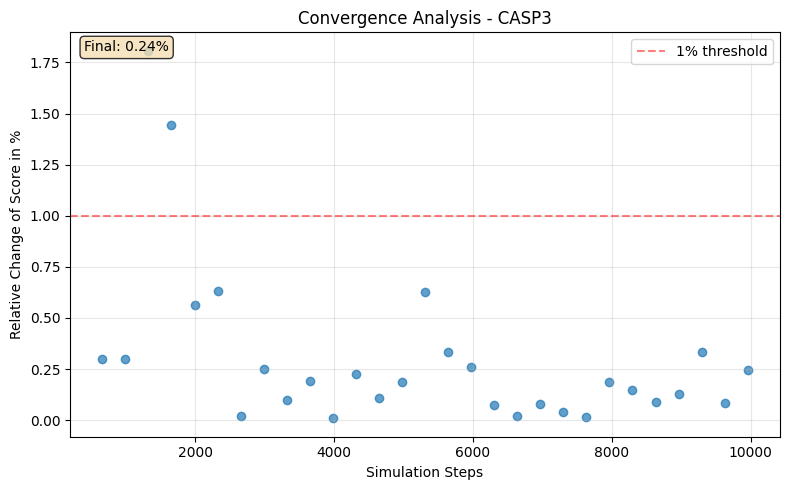

(array([0.27114577, 0.71005799, 0.59228154, 0.40411918, 0.42371526,
        0.8860228 , 0.88742252, 0.71485703, 0.75384923, 0.82043591,
        0.9110178 , 0.85382923, 0.87522496, 0.8930214 , 0.91881624,
        0.66146771, 1.        , 0.89642072, 0.87662468, 1.        ,
        0.85162967, 0.84083183, 0.85482903, 0.85762847, 0.54929014,
        0.66446711, 0.73745251, 0.74845031, 0.72645471, 0.69386123,
        0.69306139, 0.68026395, 0.51069786, 0.58628274, 0.64667067,
        0.73005399, 0.68166367, 0.78244351, 0.85602879, 0.81683663,
        0.35612877, 0.62507499, 0.74785043, 0.66426715, 0.70425915,
        0.70485903]),
 {'final_relative_change': 0.24442597978119318,
  'converged': True,
  'node_analyzed': 'CASP3',
  'relative_changes': [0.3012048192771011,
   0.3012048192771122,
   1.8072289156626509,
   1.4457831325301207,
   0.5622489959839383,
   0.6310958118187049,
   0.021514629948360398,
   0.25100401606424905,
   0.10040160642570406,
   0.191675794085433,
   0.00912741876

In [15]:
# importlib.reload(sys.modules['BNMPy.steady_state'])
# from BNMPy.steady_state import SteadyStateCalculator

calc = SteadyStateCalculator(pbn)
calc.set_experimental_conditions(stimuli=['EGF'],inhibitors=['JAK1'])
calc.compute_steady_state(method='monte_carlo',n_runs=3,n_steps=10000,p_noise=0.05,analyze_convergence=True,output_node='CASP3')

In [14]:
calc.compute_steady_state(method='tsmc',initial_nsteps=100,max_iterations=5000,freeze_constant=True)

array([0.00121627, 0.99483086, 0.98867351, 0.00190042, 0.0018244 ,
       0.99832763, 0.99445078, 0.99536298, 0.58472064, 0.99695933,
       0.99802357, 0.99870772, 0.99855568, 0.99840365, 0.99794755,
       0.58464462, 1.        , 0.9986317 , 0.80790574, 0.99536298,
       0.99490688, 0.98912961, 0.99764348, 0.99483086, 0.41847206,
       0.98669707, 0.99384265, 0.9968073 , 0.99277841, 0.58251615,
       0.66012923, 0.        , 0.9981756 , 0.99665526, 0.99513493,
       0.99239833, 0.98502471, 0.99604713, 0.99247434, 0.        ,
       0.58791334, 0.57841125, 0.9972634 , 0.57476245, 0.81596351,
       0.81140251])

## Run optimizations for all nodes
### for AsPC1

In [4]:
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 100,  # 20*number of parameters to optimize
        'iters': 1000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1,
        'ftol_iter': 5
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
        # 'method': 'monte_carlo',
        #     'monte_carlo_params': {
        #         'n_runs': 2,
        #         'n_steps': 5000,
        #         'p_noise': 0.05
        #     }
    },
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'display_rules_every': 100  # Display optimized rules every n iterations (0 = disabled)
}

In [ ]:
# self-loop model with CASP3 fixed
optimizer = Optimizer.ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned_reduced.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-08-19 16:35:49,837 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 1000
  - Problem dimensions: 84
  - Total function evaluations: 100000
  - Seed: 9


pyswarms.single.global_best:   0%|          |0/1000/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.338
2025-08-20 03:36:11,333 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3384211610613966, best pos: [0.47398056 0.61390612 0.64181568 0.60675704 0.43633339 0.61374961
 0.2938074  0.40333698 0.38272815 0.69664801 0.4039924  0.58965093
 0.44962345 0.62442293 0.48182513 0.24962211 0.49883876 0.85058914
 0.33664296 0.34886667 0.01530619 0.43254029 0.82099425 0.1541426
 0.283763   0.45814724 0.6004516  0.93437176 0.44019621 0.27145798
 0.60922856 0.77277934 0.75077839 0.14045462 0.31071765 0.45595699
 0.45345561 0.62136408 0.44465689 0.56577107 0.43848681 0.32023265
 0.31021461 0.5325106  0.50460813 0.4732721  0


Optimization attempt 2/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 1000
  - Problem dimensions: 84
  - Total function evaluations: 100000
  - Seed: 9


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.338
2025-08-20 14:36:58,251 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3384211610613966, best pos: [0.47398056 0.61390612 0.64181568 0.60675704 0.43633339 0.61374961
 0.2938074  0.40333698 0.38272815 0.69664801 0.4039924  0.58965093
 0.44962345 0.62442293 0.48182513 0.24962211 0.49883876 0.85058914
 0.33664296 0.34886667 0.01530619 0.43254029 0.82099425 0.1541426
 0.283763   0.45814724 0.6004516  0.93437176 0.44019621 0.27145798
 0.60922856 0.77277934 0.75077839 0.14045462 0.31071765 0.45595699
 0.45345561 0.62136408 0.44465689 0.56577107 0.43848681 0.32023265
 0.31021461 0.5325106  0.50460813 0.4732721  0.68210449 0.62551309
 0.33329753 0.68842014 0.70280409 0.41529785 0.3196406  0.77096604
 0.44189729 0.53096556 0.55807579 0.35814012 0.22377293 0.6453241
 0.84113691 0.36560305 0.59082366 0.82285001 0.3435983  0.5850691
 0.53189183 0.59668571 0.37272208 0.09818941 0.34086519 0.69612373


--- Optimization finished. Best MSE found: 0.338421 ---

--- Optimized PBN Rules ---
AKT1 = AktM & AktP, 0.4357
AKT1 = AKT1, 0.5643
APAF1 = TP53, 0.5140
APAF1 = APAF1, 0.4860
APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.4155
APC = APC, 0.5845
AktM = PDPK1 & PIP3, 0.4214
AktM = AktM, 0.5786
AktP = PDPK1 & PIP3, 0.3546
AktP = AktP, 0.6454
BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.4066
BAD = BAD, 0.5934
BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.4186
BCL2L1 = BCL2L1, 0.5814
BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.6587
BID = BID, 0.3413
BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.3697
BIRC2 = BIRC2, 0.6303
CASP12 = CASP7, 0.4911
CASP12 = CASP12, 0.5089
CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 1.0000
CASP6 = ! BIRC2 | CASP3, 0.0342
CASP6 = CASP6, 0.9658
CASP7 = ! BIRC2 | CASP8 | APC, 0.8419
CASP7 = CASP7, 0.1581
CASP8 = complexIIB | complexIIA | CASP6, 0.3825
CASP8 = CASP8, 0.6175
CASP9 = ! BIRC2 | ! MAPK1 | CASP3 | CASP12 | ! AKT1, 0.3912
CASP9 = CASP9, 0.6088
CFLAR = NFKB1, 0.6186
CFLAR = CF

In [ ]:
# Inhibitor wins, score_cutoff = 0.5
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 100,  # 20*number of parameters to optimize
        'iters': 1000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1,
        'ftol_iter': 5
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
        # 'method': 'monte_carlo',
        #     'monte_carlo_params': {
        #         'n_runs': 2,
        #         'n_steps': 5000,
        #         'p_noise': 0.05
        #     }
    },
    'seed': 99,
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'display_rules_every': 100  # Display optimized rules every n iterations (0 = disabled)
}
optimizer = Optimizer.ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned_reduced.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-08-20 22:02:47,442 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 1000
  - Problem dimensions: 72
  - Total function evaluations: 100000
  - Seed: 99


pyswarms.single.global_best:   1%|          |8/1000, best_cost=0.299/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.257
2025-08-21 03:58:49,774 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2566272872931221, best pos: [0.43922272 0.38195393 0.50328137 0.54166877 0.46257438 0.2343311
 0.34407182 0.30124688 0.60800563 0.40720868 0.59363503 0.5525488
 0.58388189 0.38971107 0.43439922 0.45351852 0.26512847 0.50434853
 0.54180529 0.44278225 0.30218827 0.82260825 0.05392833 0.72477478
 0.01509214 0.64146593 0.74878905 0.67349621 0.38157009 0.44582666
 0.4636196  0.4233459  0.46316737 0.10295991 0.43461884 0.43471641
 0.51199635 0.45058312 0.3527016  0.54119466 0.04624333 0.72193152
 0.33399726 0.57036878 0.39467


Optimization attempt 2/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 1000
  - Problem dimensions: 72
  - Total function evaluations: 100000
  - Seed: 99


pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.257
2025-08-21 09:57:21,521 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2566272872931221, best pos: [0.43922272 0.38195393 0.50328137 0.54166877 0.46257438 0.2343311
 0.34407182 0.30124688 0.60800563 0.40720868 0.59363503 0.5525488
 0.58388189 0.38971107 0.43439922 0.45351852 0.26512847 0.50434853
 0.54180529 0.44278225 0.30218827 0.82260825 0.05392833 0.72477478
 0.01509214 0.64146593 0.74878905 0.67349621 0.38157009 0.44582666
 0.4636196  0.4233459  0.46316737 0.10295991 0.43461884 0.43471641
 0.51199635 0.45058312 0.3527016  0.54119466 0.04624333 0.72193152
 0.33399726 0.57036878 0.39467534 0.61251684 0.52370626 0.30585578
 0.5868802  0.66097344 0.45374633 0.55296848 0.51484902 0.58040975
 0.5455786  0.55671872 0.44706691 0.44325763 0.39460992 0.19064909
 0.51407562 0.58977011 0.68926733 0.49958991 0.51460324 0.37203576
 0.35730168 0.08599397 0.62247856 0.59267385 0.58066602 0.5627319


--- Optimization finished. Best MSE found: 0.256627 ---

--- Optimized PBN Rules ---
AKT1 = !CASP3 & !PTEN & ( PDPK1 | PIK3CA ), 0.5349
AKT1 = AktM & AktP, 0.4651
APAF1 = !BCL2L1, 0.4816
APAF1 = TP53, 0.5184
APC = !BIRC2 | ( APAF1 & CASP9 & Mito ), 0.6638
APC = APC, 0.3362
AktM = PDPK1 & PIP3, 1.0000
AktP = PDPK1 & PIP3, 1.0000
BAD = !AKT1 & !MAPK8 & !RAF1 & ( BCL2L1 | CASP3 ), 0.5989
BAD = !AKT1 | !RPS6KA1 | TP53, 0.4011
BCL2L1 = !BAD & !BID & !MAPK8, 0.5179
BCL2L1 = !BAD | NFKB1 | STAT3 | !TP53, 0.4821
BID = !BCL2L1 | ( CASP8 & TP53 ) | ( MAPK8 & TP53 ), 0.5997
BID = CASP8 | MAPK8 | TP53, 0.4003
BIRC2 = !Mito | NFKB1 | ( !CASP3 & !CASP6 ), 0.4892
BIRC2 = BIRC2, 0.5108
CASP12 = CASP7, 1.0000
CASP3 = APC | !BIRC2 | CASP6 | CASP8, 0.9000
CASP3 = CASP8 | CASP9, 0.1000
CASP6 = !BIRC2 | CASP3, 0.4821
CASP6 = CASP3 | CASP8, 0.5179
CASP7 = APC | !BIRC2 | CASP8, 0.5944
CASP7 = CASP8, 0.4056
CASP8 = !CFLAR & !MAPK1 & ( CASP6 | RIPK1 ), 0.9385
CASP8 = CASP6 | complexIIA | complexIIB, 0.0615
CA

In [31]:
# Inhibitor wins, score_cutoff = 0.6
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 100,  # 20*number of parameters to optimize
        'iters': 2000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1,
        'ftol_iter': 5
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
        # 'method': 'monte_carlo',
        #     'monte_carlo_params': {
        #         'n_runs': 2,
        #         'n_steps': 5000,
        #         'p_noise': 0.05
        #     }
    },
    'seed': 99,
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'display_rules_every': 100  # Display optimized rules every n iterations (0 = disabled)
}
optimizer = Optimizer.ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned_reduced_PDPK1.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-08-22 11:15:22,914 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 2000
  - Problem dimensions: 73
  - Total function evaluations: 200000
  - Seed: 99


pyswarms.single.global_best:   0%|          |1/2000, best_cost=0.414/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=0.345
2025-08-23 00:29:40,353 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3454449166451664, best pos: [0.75399397 0.46239563 0.52835599 0.54609458 0.64288028 0.11274968
 0.48933982 0.38485922 0.80819534 0.52380934 0.55604604 0.37039025
 0.31029791 0.44770701 0.11717414 0.47904804 0.39112291 0.79578782
 0.43724248 0.32361668 0.55654351 0.71674506 0.67245231 0.01106347
 0.50475543 0.01629307 0.43911795 0.34761423 0.33674077 0.51233492
 0.26970192 0.49573763 0.7209658  0.64374053 0.52061582 0.46379882
 0.44521444 0.45613944 0.34716875 0.55746237 0.19986639 0.59141755
 0.14098688 0.77155339 0.725


Optimization attempt 2/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 2000
  - Problem dimensions: 73
  - Total function evaluations: 200000
  - Seed: 99


pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=0.345
2025-08-23 13:41:35,885 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.3454449166451664, best pos: [0.75399397 0.46239563 0.52835599 0.54609458 0.64288028 0.11274968
 0.48933982 0.38485922 0.80819534 0.52380934 0.55604604 0.37039025
 0.31029791 0.44770701 0.11717414 0.47904804 0.39112291 0.79578782
 0.43724248 0.32361668 0.55654351 0.71674506 0.67245231 0.01106347
 0.50475543 0.01629307 0.43911795 0.34761423 0.33674077 0.51233492
 0.26970192 0.49573763 0.7209658  0.64374053 0.52061582 0.46379882
 0.44521444 0.45613944 0.34716875 0.55746237 0.19986639 0.59141755
 0.14098688 0.77155339 0.72525444 0.50213222 0.64814682 0.74083436
 0.56960525 0.57054392 0.70201269 0.30286616 0.64443168 0.31939665
 0.62316671 0.562255   0.78962929 0.36108192 0.35683343 0.32624402
 0.46546256 0.37168463 0.08892526 0.69345223 0.60341582 0.39062874
 0.31095722 0.51327207 0.42211489 0.52494664 0.19011783 0.42991


--- Optimization finished. Best MSE found: 0.345445 ---

--- Optimized PBN Rules ---
AKT1 = !CASP3 & !PTEN & ( AKT1 | MAPK8 | PDPK1 | PIK3CA | TNF ), 0.6199
AKT1 = AktM & AktP, 0.3801
APAF1 = !BCL2L1, 0.4917
APAF1 = TP53, 0.5083
APC = !BIRC2 | ( APAF1 & CASP9 & Mito ), 0.8508
APC = APC, 0.1492
AktM = PDPK1 & PIP3, 1.0000
AktP = PDPK1 & PIP3, 1.0000
BAD = !AKT1 & !IKBKB & !MAPK1 & !MAPK8 & !RAF1 & !RPS6KA1 & ( BCL2L1 | CASP3 ), 0.6068
BAD = !AKT1 | !RPS6KA1 | TP53, 0.3932
BCL2L1 = !BAD & !BID & !IKBKB & !MAPK8, 0.6002
BCL2L1 = !BAD | NFKB1 | STAT3 | !TP53, 0.3998
BID = !BCL2L1 | ( CASP8 & TP53 ) | ( MAPK8 & TP53 ), 0.4094
BID = !ITCH & ( CASP8 | MAPK8 | TP53 ), 0.5906
BIRC2 = !BIRC2 & NFKB1, 0.1965
BIRC2 = !Mito | NFKB1 | ( !CASP3 & !CASP6 ), 0.8035
CASP12 = CASP12, 0.3295
CASP12 = CASP7, 0.6705
CASP3 = APC | !BIRC2 | CASP6 | CASP8, 0.9000
CASP3 = CASP8 | CASP9 | STAT3, 0.1000
CASP6 = !BIRC2 | CASP3, 0.5747
CASP6 = CASP3 | CASP8, 0.4253
CASP7 = APC | !BIRC2 | CASP8, 0.4371
CASP7 = CASP

#### AND models

In [ ]:
# &, score_cutoff = 0.5
optimizer = Optimizer.ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned_reduced_PDPK1.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-08-23 23:22:28,055 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 2000
  - Problem dimensions: 73
  - Total function evaluations: 200000
  - Seed: 99


pyswarms.single.global_best:   0%|          |1/2000, best_cost=0.0324/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
pyswarms.single.global_best: 100%|██████████|2000/2000, best_cost=0.00333
2025-08-24 14:28:30,890 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.0033336725653926908, best pos: [0.57503039 0.60179559 0.36638422 0.87203455 0.57794429 0.51007305
 0.85435691 0.67068189 0.42286047 0.75917887 0.23583333 0.43003375
 0.20096664 0.9805323  0.58411519 0.46454564 0.47769255 0.56487793
 0.72293596 0.41824433 0.35818588 0.57033451 0.03214342 0.61380922
 0.06187385 0.33304068 0.4454486  0.53056338 0.46608667 0.44188553
 0.54951906 0.81839265 0.31553226 0.59726347 0.53797651 0.38294114
 0.36424406 0.49303278 0.53434114 0.57788261 0.55211891 0.68509882
 0.0500659  0.68968125

Success threshold achieved: 0.003334 < 0.1

--- Optimization finished. Best MSE found: 0.003334 ---

--- Optimized PBN Rules ---
AKT1 = !CASP3 & PDPK1 & PIK3CA & !PTEN, 0.4886
AKT1 = AktM & AktP, 0.5114
APAF1 = !BCL2L1, 0.2958
APAF1 = TP53, 0.7042
APC = !BIRC2 | ( APAF1 & CASP9 & Mito ), 0.5312
APC = APC, 0.4688
AktM = PDPK1 & PIP3, 1.0000
AktP = PDPK1 & PIP3, 1.0000
BAD = !AKT1 & BCL2L1 & CASP3 & !MAPK8 & !RAF1, 0.3577
BAD = !AKT1 | !RPS6KA1 | TP53, 0.6423
BCL2L1 = !BAD & !BID & !MAPK8, 0.3542
BCL2L1 = !BAD | NFKB1 | STAT3 | !TP53, 0.6458
BID = !BCL2L1 | ( CASP8 & TP53 ) | ( MAPK8 & TP53 ), 0.1701
BID = CASP8 & MAPK8 & TP53, 0.8299
BIRC2 = !Mito | NFKB1 | ( !CASP3 & !CASP6 ), 0.5570
BIRC2 = BIRC2, 0.4430
CASP12 = CASP7, 1.0000
CASP3 = APC | !BIRC2 | CASP6 | CASP8, 0.9000
CASP3 = CASP8 & CASP9, 0.1000
CASP6 = !BIRC2 | CASP3, 0.4386
CASP6 = CASP3 & CASP8, 0.5614
CASP7 = APC | !BIRC2 | CASP8, 0.5387
CASP7 = CASP8, 0.4613
CASP8 = CASP6 & !CFLAR & !MAPK1 & RIPK1, 0.9466
CASP8 = CASP6 | com

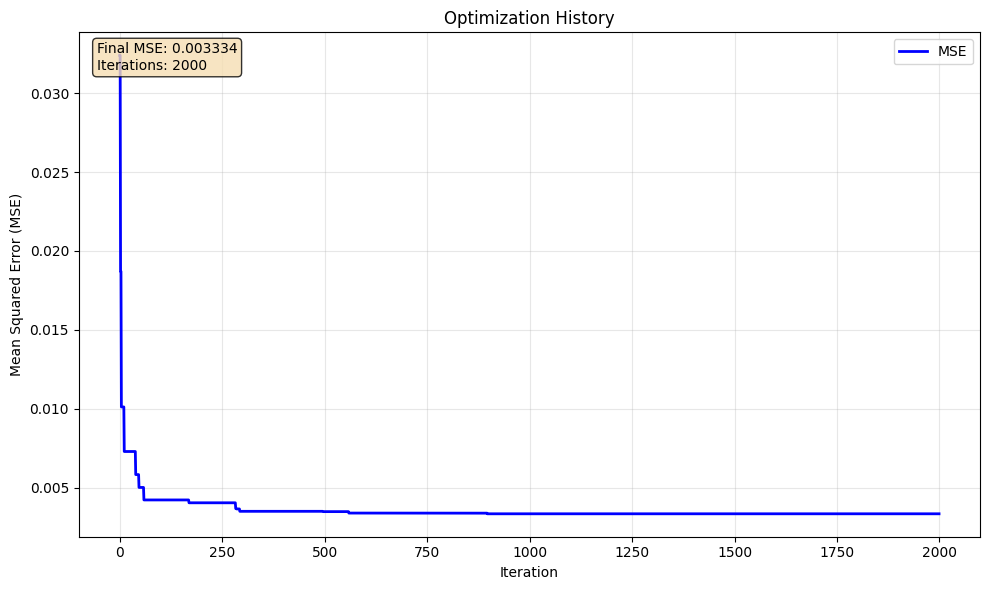

In [43]:
optimizer.plot_optimization_history(result)

In [ ]:
# &, score_cutoff = 0.7
optimizer = Optimizer.ParameterOptimizer(pbn, '../data/Eduati2020_AsPC1_cleaned_reduced_PDPK1.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

2025-08-24 16:59:18,841 - pyswarms.single.global_best - INFO - Optimize for 2000 iters with {'c1': 0.5, 'c2': 0.3, 'w': 0.9}



Optimization attempt 1/2
Running PSO optimization...


PSO Setup:
  - Particles: 100
  - Max iterations: 2000
  - Problem dimensions: 71
  - Total function evaluations: 200000
  - Seed: 99


pyswarms.single.global_best:   0%|          |1/2000, best_cost=0.186/Users/luna/Desktop/Pancreatic cancer/BNMPy/src/BNMPy/steady_state.py:362: RuntimeWarning: divide by zero encountered in scalar divide
  m0_temp = np.log10(epsilon * (alpha + beta) / max(alpha, beta)) / np.log10(abs(1 - alpha - beta))
pyswarms.single.global_best:   0%|          |2/2000, best_cost=0.186

### for BxPC3

In [ ]:
# Configure optimizer
config = {
    'pso_params': {
        'n_particles': 100,  # 20*number of parameters to optimize
        'iters': 1000,
        'options': {
            'c1': 0.5, # Cognitive parameter
            'c2': 0.3, # Social parameter
            'w': 0.9 # Inertia weight
        },
        'ftol': -1,
        'ftol_iter': 5
    },
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
        # 'method': 'monte_carlo',
        #     'monte_carlo_params': {
        #         'n_runs': 2,
        #         'n_steps': 5000,
        #         'p_noise': 0.05
        #     }
    },
    'seed': 99,
    'max_try': 2,  # Maximum number of attempts if optimization fails
    'success_threshold': 0.1, # threshold for accepting fit,
    'display_rules_every': 100  # Display optimized rules every n iterations (0 = disabled)
}
optimizer = Optimizer.ParameterOptimizer(pbn, '../data/Eduati2020_BxPC3_cleaned_reduced.csv', 
    config=config, 
    nodes_to_optimize=nodes_to_optimize, 
    verbose=True)

# Run optimization
result = optimizer.optimize(method='particle_swarm')

# Correlation between optimized and measured data
## ASPC1

In [44]:
aspc1_pbn = optimizer.get_optimized_pbn(result)
measured_nodes, perturbed_nodes = Optimizer.extract_experiment_nodes(data_aspc1_file)
BNMPy.vis_network(aspc1_pbn,"AsPC1_optimized.html",interactive=True,measured_nodes=measured_nodes,perturbed_nodes=perturbed_nodes)

   Extracted 1 measured nodes: {'CASP3'}
   Extracted 8 perturbed nodes: {'AktM', 'EGF', 'IKBKB', 'JAK1', 'PIK3CA', 'MAP2K1', 'EGFR', 'TNF'}
Network visualization saved to AsPC1_optimized.html


In [ ]:
optimized_string = """
AKT1 = AktM & AktP, 0.4007
AKT1 = AKT1, 0.5993
APAF1 = TP53, 0.5453
APAF1 = APAF1, 0.4547
APC = APAF1 & CASP9 & Mito | ! BIRC2, 0.5928
APC = APC, 0.4072
AktM = PDPK1 & PIP3, 0.4868
AktM = AktM, 0.5132
AktP = PDPK1 & PIP3, 0.5458
AktP = AktP, 0.4542
BAD = TP53 | ! RPS6KA1 | ! AKT1, 0.6384
BAD = BAD, 0.3616
BCL2L1 = ! TP53 | STAT3 | NFKB1 | ! BAD, 0.4966
BCL2L1 = BCL2L1, 0.5034
BID = MAPK8 & TP53 | CASP8 & TP53 | ! BCL2L1, 0.4115
BID = BID, 0.5885
BIRC2 = ! CASP3 & ! CASP6 | NFKB1 | ! Mito, 0.6442
BIRC2 = BIRC2, 0.3558
CASP12 = CASP7, 0.2297
CASP12 = CASP12, 0.7703
CASP3 = ! BIRC2 | CASP8 | CASP6 | APC, 0.0008
CASP3 = CASP3, 0.9992
CASP6 = ! BIRC2 | CASP3, 0.3289
CASP6 = CASP6, 0.6711
CASP7 = ! BIRC2 | CASP8 | APC, 0.5570
CASP7 = CASP7, 0.4430
CASP8 = complexIIB | complexIIA | CASP6, 0.5671
CASP8 = CASP8, 0.4329
CASP9 = ! BIRC2 | ! MAPK1 | CASP3 | CASP12 | ! AKT1, 0.5168
CASP9 = CASP9, 0.4832
CFLAR = NFKB1, 0.2976
CFLAR = CFLAR, 0.7024
EGF = EGF, 1.0000
EGFR = EGF, 0.6317
EGFR = EGFR, 0.3683
IKBKB = complexI | PDPK1 | AKT1 | ! TNFAIP3, 0.4734
IKBKB = IKBKB, 0.5266
JAK1 = EGFR, 0.5894
JAK1 = JAK1, 0.4106
KRAS = SOS1, 0.7375
KRAS = KRAS, 0.2625
MAP2K1 = RAF1 | PDPK1, 0.5300
MAP2K1 = MAP2K1, 0.4700
MAP2K4 = MAP3K1 | ! AKT1, 0.3391
MAP2K4 = MAP2K4, 0.6609
MAP3K1 = complexI | KRAS, 0.3610
MAP3K1 = MAP3K1, 0.6390
MAP3K14 = ! BIRC2, 0.3201
MAP3K14 = MAP3K14, 0.6799
MAPK1 = MAP2K1, 0.5283
MAPK1 = MAPK1, 0.4717
MAPK8 = MAP2K4, 0.4882
MAPK8 = MAPK8, 0.5118
MDM2 = TP53 | AKT1, 0.5004
MDM2 = MDM2, 0.4996
Mito = ! BCL2L1 | BID, 0.5573
Mito = Mito, 0.4427
NFKB1 = MAP3K14 | ! NFKBIA, 0.4275
NFKB1 = NFKB1, 0.5725
NFKBIA = NFKB1 | ! IKBKB, 0.5853
NFKBIA = NFKBIA, 0.4147
PDPK1 = PDPK1, 1.0000
PIK3CA = KRAS | EGFR, 0.3597
PIK3CA = PIK3CA, 0.6403
PIP3 = ! PTEN | PIK3CA, 0.4925
PIP3 = PIP3, 0.5075
PTEN = TP53, 0.4137
PTEN = PTEN, 0.5863
RAF1 = KRAS, 0.3021
RAF1 = RAF1, 0.6979
RPS6KA1 = MAPK1, 0.6769
RPS6KA1 = RPS6KA1, 0.3231
SOS1 = ! MAPK1 | EGFR, 0.6856
SOS1 = SOS1, 0.3144
STAT3 = JAK1, 0.7406
STAT3 = STAT3, 0.2594
TNF = TNF, 1.0000
TNFAIP3 = NFKB1, 0.5171
TNFAIP3 = TNFAIP3, 0.4829
TNFRSF1A = NFKB1 | TNF, 0.5247
TNFRSF1A = TNFRSF1A, 0.4753
TP53 = ! MDM2 | MAPK8 | MAPK1, 0.5648
TP53 = TP53, 0.4352
complexI = TNFRSF1A, 0.2485
complexI = complexI, 0.7515
complexIIA = complexI | ! CFLAR, 0.5189
complexIIA = complexIIA, 0.4811
complexIIB = complexI | ! BIRC2, 0.6276
complexIIB = complexIIB, 0.3724
"""
config = {
    'steady_state': {
        'method': 'tsmc',
            'tsmc_params': {
                'epsilon': 0.05, # range of transition probability [Default=0.001]
                'r': 0.1, # range of accuracy (most sensitive) [Default=0.025]
                's': 0.85, # probability to acquire defined accuracy [Default=0.95]
                'p_mir': 0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
                'initial_nsteps': 100, # initial simulation steps [Recommended at 100 steps for n < 100]
                'max_iterations': 1000, # maximum convergence iterations [Default=5000]
                'freeze_constant': True # whether to treat self-loop as a fixed node
            },
        # 'method': 'monte_carlo',
        #     'monte_carlo_params': {
        #         'n_runs': 2,
        #         'n_steps': 100000,
        #         'p_noise': 0.05
        #     }
    },
    'seed': 99
}
aspc1_pbn = BNMPy.load_pbn_from_string(optimized_string)
report = evaluate_pbn(aspc1_pbn, '../data/Eduati2020_AsPC1_cleaned_reduced.csv', output_dir='AsPC1_evaluation_results', generate_plots=True, generate_report=True, config=config)

No initial state provided, using a random initial state
PBN loaded successfully. There are 46 genes in the network.
Evaluation report saved to AsPC1_evaluation_results/evaluation_report.txt
Results exported to AsPC1_evaluation_results/detailed_results.csv


In [34]:
import sys
import importlib
importlib.reload(sys.modules['Optimizer.result_evaluation'])
from Optimizer.result_evaluation import evaluate_optimization_result, evaluate_pbn

Simulating optimized model on all experimental conditions...
  Experiment 1: 1 nodes simulated
  Experiment 2: 1 nodes simulated
  Experiment 3: 1 nodes simulated
  Experiment 4: 1 nodes simulated
  Experiment 5: 1 nodes simulated
  Experiment 6: 1 nodes simulated
  Experiment 7: 1 nodes simulated
  Experiment 8: 1 nodes simulated
Simulation completed: 8 data points
Plot saved to AsPC1_AND_cutoff0.5/prediction_vs_experimental.png
Residual plot saved to AsPC1_AND_cutoff0.5/residual_analysis.png
Evaluation report saved to AsPC1_AND_cutoff0.5/evaluation_report.txt
Results exported to AsPC1_AND_cutoff0.5/detailed_results.csv


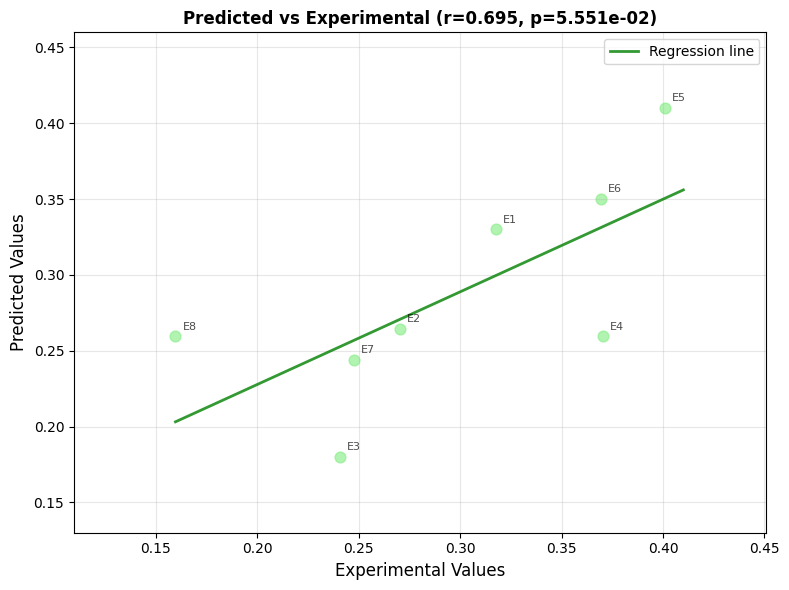

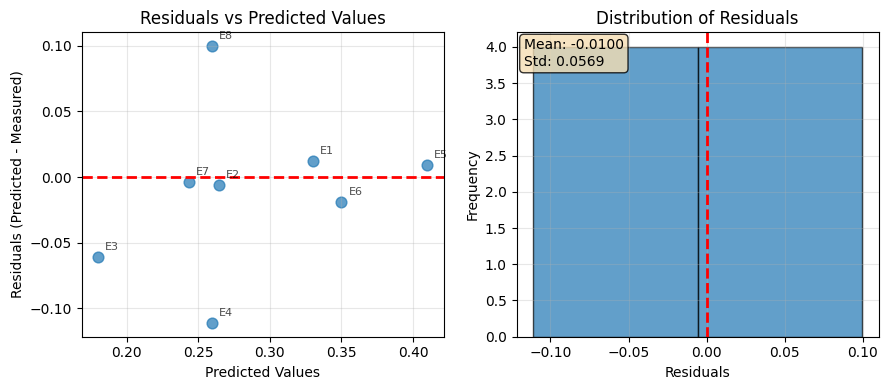

In [53]:
np.random.seed(99)
output_dir = "AsPC1_AND_cutoff0.5"
evaluator = Optimizer.evaluate_optimization_result(
    result, 
    optimizer, 
    output_dir=output_dir,
    plot_residuals=True,
    save=True,
    detailed=True,
    figsize=(8, 6)
)

# Simulate the optimized model

In [45]:
measured_nodes, perturbed_nodes = Optimizer.extract_experiment_nodes(data_aspc1_file)
perturbed_nodes

   Extracted 1 measured nodes: {'CASP3'}
   Extracted 8 perturbed nodes: {'TNF', 'PIK3CA', 'IKBKB', 'EGFR', 'AktM', 'EGF', 'MAP2K1', 'JAK1'}


{'AktM', 'EGF', 'EGFR', 'IKBKB', 'JAK1', 'MAP2K1', 'PIK3CA', 'TNF'}

In [71]:
import pandas as pd
import numpy as np
import itertools

inhibitors_genes = ['AktM','EGFR', 'IKBKB', 'JAK1', 'MAP2K1', 'PIK3CA']
stimuli_genes = ['EGF','TNF']
inhibitors = [''] # also test on untreated
for combo in itertools.combinations(inhibitors_genes, 2): # pair-wise combinations of inhibitors
    inhibitors.append(','.join(combo))
stimuli = ['EGF','EGF,TNF'] 

print(f'inhibitors: {inhibitors}')
print(f'stimuli: {stimuli}')

inhibitors: ['', 'AktM,EGFR', 'AktM,IKBKB', 'AktM,JAK1', 'AktM,MAP2K1', 'AktM,PIK3CA', 'EGFR,IKBKB', 'EGFR,JAK1', 'EGFR,MAP2K1', 'EGFR,PIK3CA', 'IKBKB,JAK1', 'IKBKB,MAP2K1', 'IKBKB,PIK3CA', 'JAK1,MAP2K1', 'JAK1,PIK3CA', 'MAP2K1,PIK3CA']
stimuli: ['EGF', 'EGF,TNF']


In [72]:
df_results = pd.DataFrame()
for stimulus in stimuli:
    for inhibitor in inhibitors:
        calc = BNMPy.SteadyStateCalculator(aspc1_pbn)
        calc.set_experimental_conditions(stimuli=[stimulus],inhibitors=[inhibitor])
        steady_state = calc.compute_steady_state(
            method='tsmc',
            epsilon=0.05, # range of transition probability [Default=0.001]
            r=0.1, # range of accuracy (most sensitive) [Default=0.025]
            s=0.85, # probability to acquire defined accuracy [Default=0.95]
            p_mir=0.01, # perturbation in Miranda's & Parga's scheme [Default=0.001, 0.1%]
            freeze_constant=True
            )
        conditions = [f"Stimulus:{stimulus}; Inhibitor:{inhibitor}"]
        print(conditions)
        df_steady_state = pd.DataFrame(steady_state,index=aspc1_pbn.nodeDict.keys(),columns=conditions).T
        df_results = pd.concat([df_results,df_steady_state])
df_results

['Stimulus:EGF; Inhibitor:']
['Stimulus:EGF; Inhibitor:AktM,EGFR']
['Stimulus:EGF; Inhibitor:AktM,IKBKB']
['Stimulus:EGF; Inhibitor:AktM,JAK1']
['Stimulus:EGF; Inhibitor:AktM,MAP2K1']
['Stimulus:EGF; Inhibitor:AktM,PIK3CA']
['Stimulus:EGF; Inhibitor:EGFR,IKBKB']
['Stimulus:EGF; Inhibitor:EGFR,JAK1']
['Stimulus:EGF; Inhibitor:EGFR,MAP2K1']
['Stimulus:EGF; Inhibitor:EGFR,PIK3CA']
['Stimulus:EGF; Inhibitor:IKBKB,JAK1']
['Stimulus:EGF; Inhibitor:IKBKB,MAP2K1']
['Stimulus:EGF; Inhibitor:IKBKB,PIK3CA']
['Stimulus:EGF; Inhibitor:JAK1,MAP2K1']
['Stimulus:EGF; Inhibitor:JAK1,PIK3CA']
['Stimulus:EGF; Inhibitor:MAP2K1,PIK3CA']
['Stimulus:EGF,TNF; Inhibitor:']
['Stimulus:EGF,TNF; Inhibitor:AktM,EGFR']
['Stimulus:EGF,TNF; Inhibitor:AktM,IKBKB']
['Stimulus:EGF,TNF; Inhibitor:AktM,JAK1']
['Stimulus:EGF,TNF; Inhibitor:AktM,MAP2K1']
['Stimulus:EGF,TNF; Inhibitor:AktM,PIK3CA']
['Stimulus:EGF,TNF; Inhibitor:EGFR,IKBKB']
['Stimulus:EGF,TNF; Inhibitor:EGFR,JAK1']
['Stimulus:EGF,TNF; Inhibitor:EGFR,MAP2K1']

,AKT1,APAF1,APC,AktM,AktP,BAD,BCL2L1,BID,BIRC2,CASP12,...,RPS6KA1,SOS1,STAT3,TNF,TNFAIP3,TNFRSF1A,TP53,complexI,complexIIA,complexIIB
Stimulus:EGF; Inhibitor:,0.021734,0.950987,0.878909,0.020182,0.016412,0.984697,0.945886,0.949878,0.802395,0.937458,...,0.849634,0.968286,0.947660,0.0,0.503216,0.500111,0.972943,0.518075,0.769350,0.617432
"Stimulus:EGF; Inhibitor:AktM,EGFR",0.019783,0.960435,0.899694,0.013931,0.017554,0.985511,0.962385,0.952076,0.701031,0.939816,...,0.881861,0.964335,0.956255,0.0,0.541098,0.565896,0.979660,0.597102,0.819170,0.721649
"Stimulus:EGF; Inhibitor:AktM,IKBKB",0.022401,0.963451,0.894478,0.020436,0.014345,0.987620,0.969739,0.949499,0.722342,0.937512,...,0.888583,0.973472,0.957556,0.0,0.545687,0.547062,0.980546,0.549224,0.772057,0.677540
"Stimulus:EGF; Inhibitor:AktM,JAK1",0.021703,0.964142,0.881340,0.028073,0.015806,0.983723,0.960132,0.935126,0.794527,0.923567,...,0.882048,0.971691,0.957065,0.0,0.503185,0.494220,0.976645,0.489974,0.784383,0.591177
"Stimulus:EGF; Inhibitor:AktM,MAP2K1",0.023200,0.946540,0.888642,0.012104,0.019367,0.987694,0.952189,0.948558,0.794634,0.915070,...,0.872705,0.973169,0.950777,0.0,0.500504,0.500101,0.972564,0.484366,0.778697,0.582207
"Stimulus:EGF; Inhibitor:AktM,PIK3CA",0.025828,0.957748,0.888967,0.017125,0.018529,0.979366,0.964627,0.948765,0.778074,0.918304,...,0.881106,0.972487,0.948344,0.0,0.516564,0.506176,0.976558,0.521617,0.777092,0.623666
"Stimulus:EGF; Inhibitor:EGFR,IKBKB",0.027264,0.958674,0.891950,0.021811,0.021667,0.984359,0.961687,0.947338,0.760367,0.935715,...,0.890372,0.971158,0.958674,0.0,0.544411,0.540537,0.977041,0.542402,0.782752,0.663366
"Stimulus:EGF; Inhibitor:EGFR,JAK1",0.027277,0.953546,0.886097,0.019342,0.020003,0.986113,0.966110,0.955199,0.770210,0.931890,...,0.877170,0.964292,0.959828,0.0,0.532485,0.527195,0.971731,0.519425,0.778310,0.645561
"Stimulus:EGF; Inhibitor:EGFR,MAP2K1",0.024503,0.956648,0.883139,0.022447,0.019191,0.983722,0.956991,0.950308,0.776731,0.930775,...,0.882111,0.966758,0.961275,0.0,0.522790,0.514393,0.974983,0.476696,0.763194,0.593729
"Stimulus:EGF; Inhibitor:EGFR,PIK3CA",0.025568,0.968094,0.898820,0.021853,0.014423,0.986451,0.957386,0.949956,0.779939,0.930944,...,0.883523,0.970280,0.958479,0.0,0.508523,0.526224,0.980114,0.536058,0.786932,0.645979


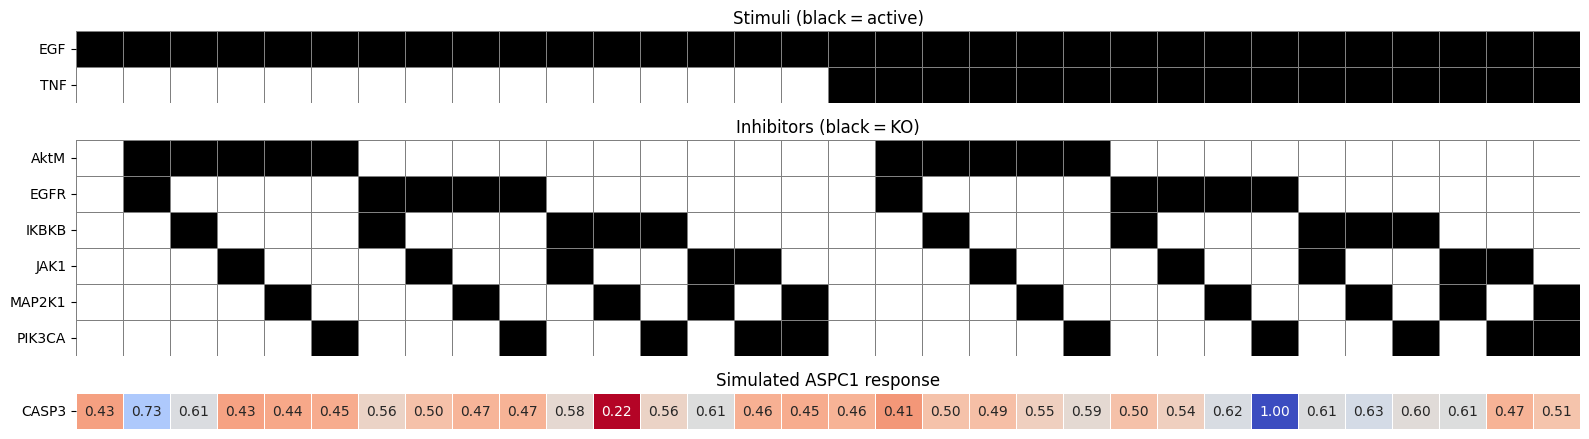

In [73]:
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

response_genes     = ['CASP3']

# build binary matrix from index strings
conditions = df_results.index.astype(str)
stimuli_block  = pd.DataFrame(0, index=stimuli_genes,      columns=conditions, dtype=int)
inhibitors_block  = pd.DataFrame(0, index=inhibitors_genes, columns=conditions, dtype=int)
for cond in conditions:
    m_stim = re.search(r"Stimulus:([^;]+)", cond)
    m_inhib = re.search(r"Inhibitor:([^;]+)", cond)
    if m_stim:
        for g in [x.strip() for x in m_stim.group(1).split(',') if x.strip().lower() not in ['none', '']]:
            if g in stimuli_block.index:        stimuli_block.loc[g, cond] = 1
    if m_inhib:
        for g in [x.strip() for x in m_inhib.group(1).split(',') if x.strip().lower() not in ['none', '']]:
            if g in inhibitors_block.index: 
                       inhibitors_block.loc[g, cond] = 1

response_block = df_results[response_genes].T

bw   = ListedColormap(['white', 'black'])
heat = sns.color_palette('coolwarm_r', as_cmap=True)
vmin, vmax = response_block.values.min(), response_block.values.max()

heights = [len(stimuli_block), len(inhibitors_block), len(response_block)]
fig, (ax_stim, ax_pert, ax_resp) = plt.subplots(
    3, 1,
    figsize=(0.5 * df_results.shape[0], 0.5 * sum(heights)),
    sharex=True,
    gridspec_kw={'height_ratios': heights}
)

sns.heatmap(stimuli_block, cmap=bw, vmin=0, vmax=1, ax=ax_stim,
            cbar=False, linewidths=.5, linecolor='grey')
ax_stim.set_title('Stimuli (black = active)')
ax_stim.set_ylabel('')
ax_stim.set_xticks([])
ax_stim.set_yticklabels(ax_stim.get_yticklabels(), rotation=0)

sns.heatmap(inhibitors_block, cmap=bw, vmin=0, vmax=1, ax=ax_pert,
            cbar=False, linewidths=.5, linecolor='grey')
ax_pert.set_title('Inhibitors (black = KO)')
ax_pert.set_ylabel('')
ax_pert.set_xticks([])
ax_pert.set_yticklabels(ax_pert.get_yticklabels(), rotation=0)

sns.heatmap(response_block, cmap=heat, vmin=vmin, vmax=vmax, ax=ax_resp,
            cbar=False, linewidths=.5, linecolor='white', annot=True, fmt='.2f')
ax_resp.set_title('Simulated ASPC1 response')
ax_resp.set_ylabel('')
ax_resp.set_xlabel('')
ax_resp.set_xticks([])
ax_resp.set_yticklabels(ax_resp.get_yticklabels(), rotation=0)

for ax in (ax_stim, ax_pert, ax_resp):
    ax.tick_params(axis='x', rotation=45, labelsize=8)

plt.tight_layout()
plt.show()